In [ ]:
# 한글 폰트를 구글 코랩에서 설치하기 위한 과정
# 런타임(세션) 다시 시작을 한 후에는 이 박스의 코드는 다시 실행하지 말고 아래의 박스부터 코드를 진행함

!apt-get update &> /dev/null
!pip install --upgrade pip

!apt -qq -y install fonts-nanum > /dev/null #  나눔폰트 설치 (한글 출력용)
!apt-get -qq install ttf-mscorefonts-installer > /dev/null # MS 기본 글꼴 설치
!sudo fc-cache -fv > /dev/null   #  폰트 캐시 초기화
!rm ~/.cache/matplotlib -rf > /dev/null  #  matplotlib 폰트 캐시 삭제

In [ ]:
!pip install kiwipiepy -q
from kiwipiepy import Kiwi

import pandas as pd
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'     #  나눔바른고딕 폰트 파일 경로 지정
font = fm.FontProperties(fname=fontpath, size=15)  #  해당 폰트를 matplotlib에 적용할 객체 생성
plt.rc('font', family='NanumBarunGothic')  #  전체 matplotlib 폰트를 나눔바른고딕으로 설정
%config InlineBackend.figure_format = 'retina'   #  시각화 이미지 품질을 'retina'로 설정하여 선명하게 출력

%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# KNU 감성분석 테스트하기

 * http://dilab.kunsan.ac.kr/knusl.html
 * KNU 감성분석은 별도의 라이브러리가 존재하지 않으므로 관련된 사전 파일을 다운받고
 * py 파일을 다운받아 실행시키거나 코드 자체를 복사해와서 실행시키는 두 가지 방법으로 진행가능함(여기서는 후자로 진행)
 * json 파일 용량은 매우 작으나 다운로드 받는데 약간 시간이 걸림

In [ ]:
# 파일 다운로드 확인
# 파일 다운로드에는 일정 시간이 필요하므로 아래 코드를 통해 확인하거나 혹은 구글드라이브에서 직접 확인가능함

import os, json
print('파일 존재:', os.path.exists('/content/drive/MyDrive/Colab/공정성/KNU/SentiWord_info.json'), '| 크기:', os.path.getsize('/content/drive/MyDrive/Colab/공정성/KNU/SentiWord_info.json'), 'bytes')
with open('/content/drive/MyDrive/Colab/공정성/KNU/SentiWord_info.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

파일 존재: True | 크기: 1183690 bytes


In [ ]:
# KNU 기반 json 파일 읽기

import json
with open('/content/drive/MyDrive/Colab/공정성/KNU/SentiWord_info.json', encoding='utf-8-sig') as f:
    data = json.load(f)
lex = {d["word"]: (d["word_root"], d["polarity"]) for d in data}

def fast_lookup(word):
    r, s = lex.get(word, ("None", "None"))
    print("어근 :", r)
    print("극성 :", s)
    return r, s

In [ ]:
# KNU 테스트해보기

fast_lookup('나쁜')

어근 : 나쁘
극성 : -2


('나쁘', '-2')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab/공정성/df100_final1524 v2.csv', encoding='utf-8', lineterminator='\n')

df1 = df.sample(2000, random_state=7777) # 샘플 2,000개만 추출해서 이후 과정 진행 / random_state 는 seed 값과 유사한 역할
df1 = df1.reset_index()

df1.head()

,index,Date,Url,Title,Content,News,Style,Year,Char,Nouns,Nouns_cleaned,Admin,Period\r
0,2050,2019.11.28,https://www.chosun.com/site/data/html_dir/2019...,"[단독] '겨울왕국2' 스크린 2648개↑점유율 79%→디즈니 ""공식입장無""..무법...",[OSEN=김보라 기자] 영화 ‘겨울왕국2’가 1편 ‘겨울왕국’(2014)에 이어 ...,조선,Con,2019,160,김보라 기자 영화 겨울왕국 겨울왕국 관객 돌파 모양새 관객 돌파 평일 일일 관객 극...,김보라 영화 겨울왕국 겨울왕국 관객 돌파 모양새 관객 돌파 평일 일일 관객 극장 겨...,Pro,5
1,3292,2017.10.13,https://www.chosun.com/site/data/html_dir/2017...,"SBS, 한국 방송 초유의 '사장 임명동의제' 도입",SBS와 SBS 노동조합은 지난 9월 11일 윤세영 회장의 소유와 경영 분리 선언을...,조선,Con,2017,105,노동조합 윤세영 회장 소유 경영 분리 선언 실행 후속 조치 합의 편성 시사 교양 보...,노동조합 윤세영 회장 소유 경영 분리 선언 실행 후속 조치 합의 편성 시사 교양 최...,Pro,3
2,18082,2020. 12. 15,https://www.khan.co.kr/article/202012152056005,윤 총장 측 ‘하루 연장’ 요청했지만 거부…최후진술 없이 종결,법무부 검사징계위원회는 15일 2차 심의를 열고 윤석열 검찰총장에 대한 징계 여부를...,경향,Pro,2020,384,법무부 검사 징계 위원회 심의 윤석열 검찰 총장 징계 여부 논의 징계위 총장 저녁 ...,법무부 검사 징계 위원회 심의 윤석열 검찰 총장 징계 여부 논의 징계위 총장 저녁 ...,Pro,6
3,16475,2023-12-10,https://www.hani.co.kr/arti/opinion/column/111...,브로커와 매관매직,[한겨레 프리즘] 박수지 | 이슈팀장 “나 청와대 실장인데….” 2021년 말께 자...,한겨레,Pro,2023,252,한겨레 프리즘 수지 이슈 팀장 청와대 실장 자신 소개 사람 서울경찰청장 전화 서울 ...,한겨레 프리즘 수지 이슈 팀장 청와대 실장 소개 서울경찰청장 전화 서울 시내 경찰서...,Con,9
4,10281,2016-11-24,https://www.donga.com/news/article/all/2016112...,새누리 정진석-민주 우상호 SNS로 질의·응답…무슨 내용 담겼나?,"정진석, 우상호. 동아일보DB새누리당 정진석 원내대표와 더불어민주당 우상호 원내대표...",동아,Con,2016,233,정진석 우상호 동아일보 새누리당 정진석 원내 대표 더불어민주당 우상호 원내 대표 민...,정진석 우상호 동아일보 새누리당 정진석 원내 대표 더불어민주당 우상호 원내 대표 민...,Con,2


In [ ]:
# 형태소 추출 테스트: 지난 번보다 동사(VV), 형용사(VA), 부사(MAG) 추가함

kiwi = Kiwi(model_type='sbg')

results = kiwi.analyze(df1['Content'][0])
extracted_morphs = []
for result in results:
    for morphtag in result[0]:  # 각 형태소/태그 쌍에 대해 반복
        morph = morphtag[0]  # 형태소와 태그 언패킹
        tag = morphtag[1]
        if tag in ('NNG', 'NNP', 'VV', 'VA', 'MAG') and len(morph) >= 2: # 두 글자 이상의 일반명사, 고유명사, 동사, 형용사, 부사까지
            extracted_morphs.append(morph)

' '.join(extracted_morphs) # tokenized 된 텍스트를 원래대로 하나의 텍스트로 처리

'김보라 기자 영화 겨울왕국 겨울왕국 다시 관객 돌파 모양새 관객 돌파 앞서 평일 무려 웃돌 일일 관객 극장 겨울왕국 상영 가운데 한편 숫자 이면 들이 필요 애니메이션 겨울왕국 감독 크리스 벅제니퍼 수입 배급 월트 디즈니 컴퍼니 숨기 과거 비밀 운명 위하 모험 떠나 엘사 안나 이야기 그리 돌아오 성장 어린이 청소년 물론 성인 관객 눈높이 맞추 전체 스토리 한층 감동 그리 디즈니 흥행 전략 세대 관객 시장 논리 감안 전체 좌석 영화 차지 문제 겨울왕국 개봉 당일 이달 좌석 점유 스크린 영진위 제공 이하 동일 달하 현재 우리나라 스크린 독과점 대하 규제 상황 최근 특정 영화 상영관 스크린 제한 나오 스크린 질서 난무 영화인 대책위 독과점 영대 겨울왕국 개봉 시기 맞물리 지나 영화 다양 확보 독과점 해소 시장 공정 회복 주제 문제 해결 촉구 기자 회견 주장 특정 영화 스크린 과도 점유 스크린 독과점 지적 다양 영화 관람 원하 관객 선택 침해 한국 영화 다양 저해 관련 멀티플렉스 극장 관계자 관객 겨울왕국 많이 입장 되풀이 또한 월트 디즈니 컴퍼니 스크린 차지 좌석 점유 기록 상황 대하 함구 월트 디즈니 컴퍼니 공식 입장 드리 말씀 독과점 지적 대하 사안 대답 내놓 앞서 국내 개봉 어벤져스: 엔드게임 상영 당시 개봉 스크린 넘기 한편 영화 스크린 상한 도입 추진 나오 수차례 발의 상정'

In [ ]:
# 형태소 분석 및 품사 태깅 실행

def extract_morphs(text):
    results = kiwi.analyze(text)
    extracted_morphs = []
    for result in results:
        for morphtag in result[0]:  # 각 형태소/태그 쌍에 대해 반복
            morph = morphtag[0]  # 형태소와 태그 언패킹
            tag = morphtag[1]
            if tag in ('NNG', 'NNP', 'VV', 'VA', 'MAG') and len(morph) >= 2:
                extracted_morphs.append(morph)

    return ' '.join(extracted_morphs)

# 각 텍스트에 대해 형태소 추출
morphs_list = [extract_morphs(text) for text in df1['Content']]
df1['Tokens'] = morphs_list

df1

,index,Date,Url,Title,Content,News,Style,Year,Char,Nouns,Nouns_cleaned,Admin,Period\r,Tokens
0,2050,2019.11.28,https://www.chosun.com/site/data/html_dir/2019...,"[단독] '겨울왕국2' 스크린 2648개↑점유율 79%→디즈니 ""공식입장無""..무법...",[OSEN=김보라 기자] 영화 ‘겨울왕국2’가 1편 ‘겨울왕국’(2014)에 이어 ...,조선,Con,2019,160,김보라 기자 영화 겨울왕국 겨울왕국 관객 돌파 모양새 관객 돌파 평일 일일 관객 극...,김보라 영화 겨울왕국 겨울왕국 관객 돌파 모양새 관객 돌파 평일 일일 관객 극장 겨...,Pro,5,김보라 기자 영화 겨울왕국 겨울왕국 다시 관객 돌파 모양새 관객 돌파 앞서 평일 무...
1,3292,2017.10.13,https://www.chosun.com/site/data/html_dir/2017...,"SBS, 한국 방송 초유의 '사장 임명동의제' 도입",SBS와 SBS 노동조합은 지난 9월 11일 윤세영 회장의 소유와 경영 분리 선언을...,조선,Con,2017,105,노동조합 윤세영 회장 소유 경영 분리 선언 실행 후속 조치 합의 편성 시사 교양 보...,노동조합 윤세영 회장 소유 경영 분리 선언 실행 후속 조치 합의 편성 시사 교양 최...,Pro,3,노동조합 지나 윤세영 회장 소유 경영 분리 선언 실행 후속 조치 합의 편성 시사 교...
2,18082,2020. 12. 15,https://www.khan.co.kr/article/202012152056005,윤 총장 측 ‘하루 연장’ 요청했지만 거부…최후진술 없이 종결,법무부 검사징계위원회는 15일 2차 심의를 열고 윤석열 검찰총장에 대한 징계 여부를...,경향,Pro,2020,384,법무부 검사 징계 위원회 심의 윤석열 검찰 총장 징계 여부 논의 징계위 총장 저녁 ...,법무부 검사 징계 위원회 심의 윤석열 검찰 총장 징계 여부 논의 징계위 총장 저녁 ...,Pro,6,법무부 검사 징계 위원회 심의 윤석열 검찰 총장 대하 징계 여부 논의 징계위 총장 ...
3,16475,2023-12-10,https://www.hani.co.kr/arti/opinion/column/111...,브로커와 매관매직,[한겨레 프리즘] 박수지 | 이슈팀장 “나 청와대 실장인데….” 2021년 말께 자...,한겨레,Pro,2023,252,한겨레 프리즘 수지 이슈 팀장 청와대 실장 자신 소개 사람 서울경찰청장 전화 서울 ...,한겨레 프리즘 수지 이슈 팀장 청와대 실장 소개 서울경찰청장 전화 서울 시내 경찰서...,Con,9,한겨레 프리즘 수지 이슈 팀장 청와대 실장 자신 소개 사람 서울 경찰청장 직접 전화...
4,10281,2016-11-24,https://www.donga.com/news/article/all/2016112...,새누리 정진석-민주 우상호 SNS로 질의·응답…무슨 내용 담겼나?,"정진석, 우상호. 동아일보DB새누리당 정진석 원내대표와 더불어민주당 우상호 원내대표...",동아,Con,2016,233,정진석 우상호 동아일보 새누리당 정진석 원내 대표 더불어민주당 우상호 원내 대표 민...,정진석 우상호 동아일보 새누리당 정진석 원내 대표 더불어민주당 우상호 원내 대표 민...,Con,2,정진석 우상호 동아일보 새누리당 정진석 원내 대표 더불어민주당 우상호 원내 대표 민...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,14711,2018-02-12,https://www.hani.co.kr/arti/politics/defense/8...,군 지휘관 ‘재판 개입’ 차단…군 법원장 민간 법조인으로,"국방부가 12일 발표한 군 사법개혁안은 군사재판의 독립성과 공정성을 확보해, 군 사...",한겨레,Pro,2018,337,국방부 발표 사법 개혁 군사 재판 독립 공정 확보 사법 분야 장병 인권 보장 중점 ...,국방부 발표 사법 개혁 군사 재판 독립 공정 확보 사법 분야 장병 인권 보장 중점 ...,Pro,4,국방부 발표 사법 개혁 군사 재판 독립 공정 확보 사법 분야 장병 인권 보장 중점 ...
1996,18274,2020. 08. 26,https://www.khan.co.kr/article/202008260600015,코로나 시대의 입시 혼란…‘고3 불리론’ 해법은,■ ‘수업 파행’ 고3에 실질적인 구제책은? 코로나19 때문에 1학기 내내 수업 파...,경향,Pro,2020,480,수업 파행 고3 실질 구제책 코로나 학기 수업 파행 고3 내년도 입시 불리 인식 대...,수업 파행 실질 구제책 코로나 학기 수업 파행 내년도 입시 불리 인식 대두 수능 난...,Pro,6,수업 파행 실질 구제책 코로나 때문 학기 내내 수업 파행 내년도 입시 불리 인식 대...
1997,15611,2015-11-20,https://www.hani.co.kr/arti/society/society_ge...,노동법도 ‘합의’ 무시…‘민주주의 시계’ 거꾸로 돈다,전국교직원노동조합 소속 교사들이 20일 오후 서울 태평로1가 서울파이낸스센터 앞에서...,한겨레,Pro,2015,332,전국교직원노동조합 소속 교사 오후 서울 태평로 서울 파이낸스 센터 역사 교과서 국정...,전국교직원노동조합 소속 교사 오후 서울 태평로 서울 파이낸스 센터 역사 교과서 국정...,Con,1,전국교직원노동조합 소속 교사 오후 서울 태평로 서울 파이낸스 센터 역사 교과서 국정...
1998,3085,2018.02.06,https://www.chosun.com/site/data/html_dir/2018...,"[평창 SNS]올림픽 물거품 경성현 ""지친다 스키타고 싶다""",평창동계올림픽 출전 꿈이 무산된 알파인 스키 국가대표 경성현(홍천군청)이 자신의 S...,조선,Con,2018,208,평창 동계 올림픽 출전 무산 알파인 스키 국가 대표 경성현 홍천 군청 자신 심경 최...,평창 동계 올림픽 출전 무산 알파인 스키 국가 대표 경성현 홍천 군청 심경 최근 대...,Pro,4,평창 동계 올림픽 출전 무산 알파인 스키 국가 대표 경성현 홍천 군청 자신 통하 심...


In [ ]:
# 단어별 / 어근별 극성 딕셔너리
lex_word = {d["word"]: float(d["polarity"]) if d["polarity"] not in ("None", None, "") else None for d in data}
lex_root = {d["word_root"]: float(d["polarity"]) if d["polarity"] not in ("None", None, "") else None for d in data}

# 전처리 결과를 토크나이즈하기
df1["Tokenize"] = df1["Tokens"].astype(str).apply(lambda x: x.strip().split())

# KNU 감성 사전에 매칭하여 (단어, 점수, 종류) 튜플 생성
df1["KNU_hits"] = df1["Tokenize"].apply(
    lambda toks: [
        (w, lex_word[w], "word") if w in lex_word and lex_word[w] is not None else # 단어 사전에 있고 점수가 존재하면 'word'로 기록
        (w, lex_root[w], "root") if w in lex_root and lex_root[w] is not None else # 어근 사전에 있고 점수가 존재하면 'root'로 기록
        (w, None, None) # 사전에 없으면 점수 없음으로 처리
        for w in toks # 모든 토큰에 대해 반복
    ]
)

In [ ]:
df1['KNU_hits'][0]

[('김보라', None, None),
 ('기자', None, None),
 ('영화', None, None),
 ('겨울왕국', None, None),
 ('겨울왕국', None, None),
 ('다시', None, None),
 ('관객', None, None),
 ('돌파', None, None),
 ('모양새', None, None),
 ('관객', None, None),
 ('돌파', None, None),
 ('앞서', None, None),
 ('평일', None, None),
 ('무려', None, None),
 ('웃돌', None, None),
 ('일일', None, None),
 ('관객', None, None),
 ('극장', None, None),
 ('겨울왕국', None, None),
 ('상영', None, None),
 ('가운데', None, None),
 ('한편', None, None),
 ('숫자', None, None),
 ('이면', None, None),
 ('들이', None, None),
 ('필요', 1.0, 'root'),
 ('애니메이션', None, None),
 ('겨울왕국', None, None),
 ('감독', None, None),
 ('크리스', None, None),
 ('벅제니퍼', None, None),
 ('수입', None, None),
 ('배급', None, None),
 ('월트', None, None),
 ('디즈니', None, None),
 ('컴퍼니', None, None),
 ('숨기', None, None),
 ('과거', None, None),
 ('비밀', None, None),
 ('운명', None, None),
 ('위하', 1.0, 'root'),
 ('모험', None, None),
 ('떠나', None, None),
 ('엘사', None, None),
 ('안나', None, None),
 ('이야기', -1.0, 'root'),
 ('그리', No

In [ ]:
# 문서별 총점 계산
df1["KNU_score"] = df1["KNU_hits"].apply(lambda hits: sum(p for _, p, _ in hits if p is not None))  # 감성 점수가 있는 경우만 합산하여 문서별 총점 생성

# 긍정/부정 요약 정보 생성
df1["KNU_summary"] = df1["KNU_hits"].apply(
    lambda hits: {
        "pos_freq": sum(1 for _, p, _ in hits if p is not None and p > 0),  # 긍정 단어 빈도 (점수 > 0)
        "neg_freq": sum(1 for _, p, _ in hits if p is not None and p < 0),  # 부정 단어 빈도 (점수 < 0)
        "pos_sum":  sum(p for _, p, _ in hits if p is not None and p > 0),  # 긍정 점수 총합
        "neg_sum":  sum(p for _, p, _ in hits if p is not None and p < 0),  # 부정 점수 총합
        "net_sum":  sum(p for _, p, _ in hits if p is not None) # 전체 감성 점수 총합
    }
)

df1.head()

,index,Date,Url,Title,Content,News,Style,Year,Char,Nouns,Nouns_cleaned,Admin,Period\r,Tokens,Tokenize,KNU_hits,KNU_score,KNU_summary
0,2050,2019.11.28,https://www.chosun.com/site/data/html_dir/2019...,"[단독] '겨울왕국2' 스크린 2648개↑점유율 79%→디즈니 ""공식입장無""..무법...",[OSEN=김보라 기자] 영화 ‘겨울왕국2’가 1편 ‘겨울왕국’(2014)에 이어 ...,조선,Con,2019,160,김보라 기자 영화 겨울왕국 겨울왕국 관객 돌파 모양새 관객 돌파 평일 일일 관객 극...,김보라 영화 겨울왕국 겨울왕국 관객 돌파 모양새 관객 돌파 평일 일일 관객 극장 겨...,Pro,5,김보라 기자 영화 겨울왕국 겨울왕국 다시 관객 돌파 모양새 관객 돌파 앞서 평일 무...,"[김보라, 기자, 영화, 겨울왕국, 겨울왕국, 다시, 관객, 돌파, 모양새, 관객,...","[(김보라, None, None), (기자, None, None), (영화, Non...",10.0,"{'pos_freq': 16, 'neg_freq': 8, 'pos_sum': 21...."
1,3292,2017.10.13,https://www.chosun.com/site/data/html_dir/2017...,"SBS, 한국 방송 초유의 '사장 임명동의제' 도입",SBS와 SBS 노동조합은 지난 9월 11일 윤세영 회장의 소유와 경영 분리 선언을...,조선,Con,2017,105,노동조합 윤세영 회장 소유 경영 분리 선언 실행 후속 조치 합의 편성 시사 교양 보...,노동조합 윤세영 회장 소유 경영 분리 선언 실행 후속 조치 합의 편성 시사 교양 최...,Pro,3,노동조합 지나 윤세영 회장 소유 경영 분리 선언 실행 후속 조치 합의 편성 시사 교...,"[노동조합, 지나, 윤세영, 회장, 소유, 경영, 분리, 선언, 실행, 후속, 조치...","[(노동조합, None, None), (지나, None, None), (윤세영, N...",2.0,"{'pos_freq': 10, 'neg_freq': 7, 'pos_sum': 13...."
2,18082,2020. 12. 15,https://www.khan.co.kr/article/202012152056005,윤 총장 측 ‘하루 연장’ 요청했지만 거부…최후진술 없이 종결,법무부 검사징계위원회는 15일 2차 심의를 열고 윤석열 검찰총장에 대한 징계 여부를...,경향,Pro,2020,384,법무부 검사 징계 위원회 심의 윤석열 검찰 총장 징계 여부 논의 징계위 총장 저녁 ...,법무부 검사 징계 위원회 심의 윤석열 검찰 총장 징계 여부 논의 징계위 총장 저녁 ...,Pro,6,법무부 검사 징계 위원회 심의 윤석열 검찰 총장 대하 징계 여부 논의 징계위 총장 ...,"[법무부, 검사, 징계, 위원회, 심의, 윤석열, 검찰, 총장, 대하, 징계, 여부...","[(법무부, None, None), (검사, None, None), (징계, Non...",-17.0,"{'pos_freq': 10, 'neg_freq': 21, 'pos_sum': 13..."
3,16475,2023-12-10,https://www.hani.co.kr/arti/opinion/column/111...,브로커와 매관매직,[한겨레 프리즘] 박수지 | 이슈팀장 “나 청와대 실장인데….” 2021년 말께 자...,한겨레,Pro,2023,252,한겨레 프리즘 수지 이슈 팀장 청와대 실장 자신 소개 사람 서울경찰청장 전화 서울 ...,한겨레 프리즘 수지 이슈 팀장 청와대 실장 소개 서울경찰청장 전화 서울 시내 경찰서...,Con,9,한겨레 프리즘 수지 이슈 팀장 청와대 실장 자신 소개 사람 서울 경찰청장 직접 전화...,"[한겨레, 프리즘, 수지, 이슈, 팀장, 청와대, 실장, 자신, 소개, 사람, 서울...","[(한겨레, None, None), (프리즘, None, None), (수지, No...",5.0,"{'pos_freq': 23, 'neg_freq': 16, 'pos_sum': 32..."
4,10281,2016-11-24,https://www.donga.com/news/article/all/2016112...,새누리 정진석-민주 우상호 SNS로 질의·응답…무슨 내용 담겼나?,"정진석, 우상호. 동아일보DB새누리당 정진석 원내대표와 더불어민주당 우상호 원내대표...",동아,Con,2016,233,정진석 우상호 동아일보 새누리당 정진석 원내 대표 더불어민주당 우상호 원내 대표 민...,정진석 우상호 동아일보 새누리당 정진석 원내 대표 더불어민주당 우상호 원내 대표 민...,Con,2,정진석 우상호 동아일보 새누리당 정진석 원내 대표 더불어민주당 우상호 원내 대표 민...,"[정진석, 우상호, 동아일보, 새누리당, 정진석, 원내, 대표, 더불어민주당, 우상...","[(정진석, None, None), (우상호, None, None), (동아일보, ...",19.0,"{'pos_freq': 25, 'neg_freq': 10, 'pos_sum': 33..."


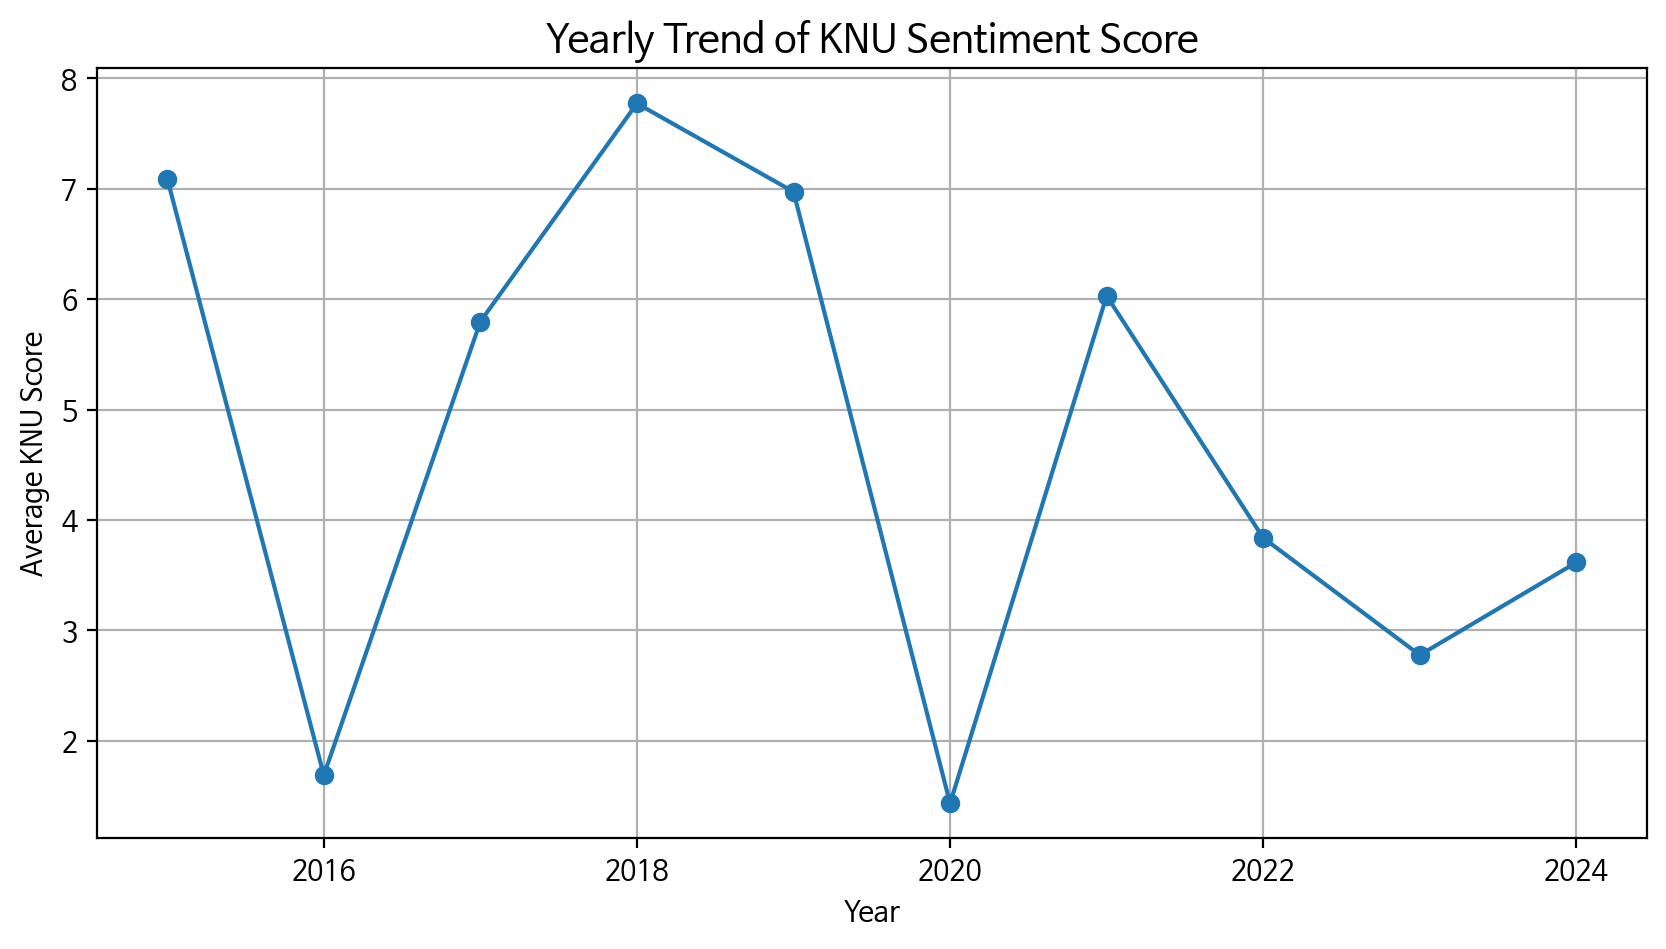

In [ ]:
# 연도별 평균치로 시각화하기

yearly = df1.groupby("Year")["KNU_score"].mean().reset_index()

plt.figure(figsize=(10,5))
plt.plot(yearly["Year"], yearly["KNU_score"], marker='o')
plt.title("Yearly Trend of KNU Sentiment Score", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Average KNU Score")
plt.grid(True)
plt.show();

# eKoNLPy 테스트하기
* https://github.com/entelecheia/eKoNLPy
* eKoNLPy는 경제 분석을 위해 설계된 NLP 파이썬 라이브러리
* KoNLPy의 Mecab 태거 기능을 확장하여 경제 용어, 금융 기관, 기업명을 단일 명사로 분류함으로써 처리 성능을 향상시킴(단, Mecab 기반이기 때문에 본 수업에서 예시로 다룬 kiwipiepy와 결과가 상이함)
* 통화 정책 성명서의 어조(매파적 또는 비둘기파적 등)를 판단하기 위한 감정 분석 기능을 통합

In [ ]:
!pip install konlpy -q
!pip install ekonlpy -q

from ekonlpy.sentiment import KSA

  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'mecab-ko-dic' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'mecab-ko-dic'. Discussion can be found at https://github.com/pypa/pip/issues/6334
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.1 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.


In [ ]:
ksa = KSA()

# KSA 토큰화 및 감성 점수 계산
# ksa.tokenize(text): 텍스트를 KSA 전용 토큰 시퀀스로 변환
# ksa.get_score(tokens): 토큰 시퀀스를 받아 양/음/중립을 반영한 수치 점수 반환(점수의 부호: 양수=긍정, 음수=부정, 0=중립/불확실)

ksa_tokens_col = []
ksa_score_col  = []

for t in df1['Tokens']:
    toks  = ksa.tokenize(t) # 토큰 시퀀스
    score = ksa.get_score(toks) # 수치 점수(양수/음수/0)
    ksa_tokens_col.append(toks)
    ksa_score_col.append(score)

df1['ksa_tokens'] = ksa_tokens_col
df1['ksa_score']  = ksa_score_col

df1.head()

,index,Date,Url,Title,Content,News,Style,Year,Char,Nouns,Nouns_cleaned,Admin,Period\r,Tokens,Tokenize,KNU_hits,KNU_score,KNU_summary,ksa_tokens,ksa_score
0,2050,2019.11.28,https://www.chosun.com/site/data/html_dir/2019...,"[단독] '겨울왕국2' 스크린 2648개↑점유율 79%→디즈니 ""공식입장無""..무법...",[OSEN=김보라 기자] 영화 ‘겨울왕국2’가 1편 ‘겨울왕국’(2014)에 이어 ...,조선,Con,2019,160,김보라 기자 영화 겨울왕국 겨울왕국 관객 돌파 모양새 관객 돌파 평일 일일 관객 극...,김보라 영화 겨울왕국 겨울왕국 관객 돌파 모양새 관객 돌파 평일 일일 관객 극장 겨...,Pro,5,김보라 기자 영화 겨울왕국 겨울왕국 다시 관객 돌파 모양새 관객 돌파 앞서 평일 무...,"[김보라, 기자, 영화, 겨울왕국, 겨울왕국, 다시, 관객, 돌파, 모양새, 관객,...","[(김보라, None, None), (기자, None, None), (영화, Non...",10.0,"{'pos_freq': 16, 'neg_freq': 8, 'pos_sum': 21....","[영화/NNG, 겨울/NNG, 겨울/NNG, 다시/MAG, 앞/NNG, 극장/NNG...","{'Positive': 62, 'Negative': -33, 'Polarity': ..."
1,3292,2017.10.13,https://www.chosun.com/site/data/html_dir/2017...,"SBS, 한국 방송 초유의 '사장 임명동의제' 도입",SBS와 SBS 노동조합은 지난 9월 11일 윤세영 회장의 소유와 경영 분리 선언을...,조선,Con,2017,105,노동조합 윤세영 회장 소유 경영 분리 선언 실행 후속 조치 합의 편성 시사 교양 보...,노동조합 윤세영 회장 소유 경영 분리 선언 실행 후속 조치 합의 편성 시사 교양 최...,Pro,3,노동조합 지나 윤세영 회장 소유 경영 분리 선언 실행 후속 조치 합의 편성 시사 교...,"[노동조합, 지나, 윤세영, 회장, 소유, 경영, 분리, 선언, 실행, 후속, 조치...","[(노동조합, None, None), (지나, None, None), (윤세영, N...",2.0,"{'pos_freq': 10, 'neg_freq': 7, 'pos_sum': 13....","[선언/NNG, 합의/NNG, 최고/NNG, 대표/NNG, 동의/NNG, 대표/NN...","{'Positive': 24, 'Negative': -18, 'Polarity': ..."
2,18082,2020. 12. 15,https://www.khan.co.kr/article/202012152056005,윤 총장 측 ‘하루 연장’ 요청했지만 거부…최후진술 없이 종결,법무부 검사징계위원회는 15일 2차 심의를 열고 윤석열 검찰총장에 대한 징계 여부를...,경향,Pro,2020,384,법무부 검사 징계 위원회 심의 윤석열 검찰 총장 징계 여부 논의 징계위 총장 저녁 ...,법무부 검사 징계 위원회 심의 윤석열 검찰 총장 징계 여부 논의 징계위 총장 저녁 ...,Pro,6,법무부 검사 징계 위원회 심의 윤석열 검찰 총장 대하 징계 여부 논의 징계위 총장 ...,"[법무부, 검사, 징계, 위원회, 심의, 윤석열, 검찰, 총장, 대하, 징계, 여부...","[(법무부, None, None), (검사, None, None), (징계, Non...",-17.0,"{'pos_freq': 10, 'neg_freq': 21, 'pos_sum': 13...","[검사/NNG, 열/VV, 여부/NNG, 논의/NNG, 최후/NNG, 정부/NNG,...","{'Positive': 44, 'Negative': -66, 'Polarity': ..."
3,16475,2023-12-10,https://www.hani.co.kr/arti/opinion/column/111...,브로커와 매관매직,[한겨레 프리즘] 박수지 | 이슈팀장 “나 청와대 실장인데….” 2021년 말께 자...,한겨레,Pro,2023,252,한겨레 프리즘 수지 이슈 팀장 청와대 실장 자신 소개 사람 서울경찰청장 전화 서울 ...,한겨레 프리즘 수지 이슈 팀장 청와대 실장 소개 서울경찰청장 전화 서울 시내 경찰서...,Con,9,한겨레 프리즘 수지 이슈 팀장 청와대 실장 자신 소개 사람 서울 경찰청장 직접 전화...,"[한겨레, 프리즘, 수지, 이슈, 팀장, 청와대, 실장, 자신, 소개, 사람, 서울...","[(한겨레, None, None), (프리즘, None, None), (수지, No...",5.0,"{'pos_freq': 23, 'neg_freq': 16, 'pos_sum': 32...","[소개/NNG, 사람/NNG, 직접/NNG, 전화/NNG, 과장/NNG, 승진/NN...","{'Positive': 54, 'Negative': -53, 'Polarity': ..."
4,10281,2016-11-24,https://www.donga.com/news/article/all/2016112...,새누리 정진석-민주 우상호 SNS로 질의·응답…무슨 내용 담겼나?,"정진석, 우상호. 동아일보DB새누리당 정진석 원내대표와 더불어민주당 우상호 원내대표...",동아,Con,2016,233,정진석 우상호 동아일보 새누리당 정진석 원내 대표 더불어민주당 우상호 원내 대표 민...,정진석 우상호 동아일보 새누리당 정진석 원내 대표 더불어민주당 우상호 원내 대표 민...,Con,2,정진석 우상호 동아일보 새누리당 정진석 원내 대표 더불어민주당 우상호 원내 대표 민...,"[정진석, 우상호, 동아일보, 새누리당, 정진석, 원내, 대표, 더불어민주당, 우상...","[(정진석, None, None), (우상호, None, None), (동아일보, ...",19.0,"{'pos_freq': 25, 'neg_freq': 10, 'pos_sum': 33...","[정/NNG, 정/NNG, 대표/NNG, 대표/NNG, 처리/NNG, 의견/NNG,...","{'Positive': 59, 'Negative': -34, 'Polarity': ..."


* eKoNLPy 의 분석 결과
    * Positive: 긍정 어휘의 가중치 총합
    * Negative: 부정 어휘의 가중치 총합
    * Polarity(Positive+Negative)/(∣Positive∣+∣Negative∣): 긍부정 방향이나 강도(세기) 추정
    * Subjectivity: 문장이 얼마나 ‘주관적’(의견/감정 중심)인지 나타내는 지표이며 결국 감성 어휘의 빈도에 따라 결정됨(1에 가까울수록 주관적)

In [ ]:
df1['ksa_score'][0]

{'Positive': 62,
 'Negative': -33,
 'Polarity': 0.3052631546814405,
 'Subjectivity': 0.9999999894736844}

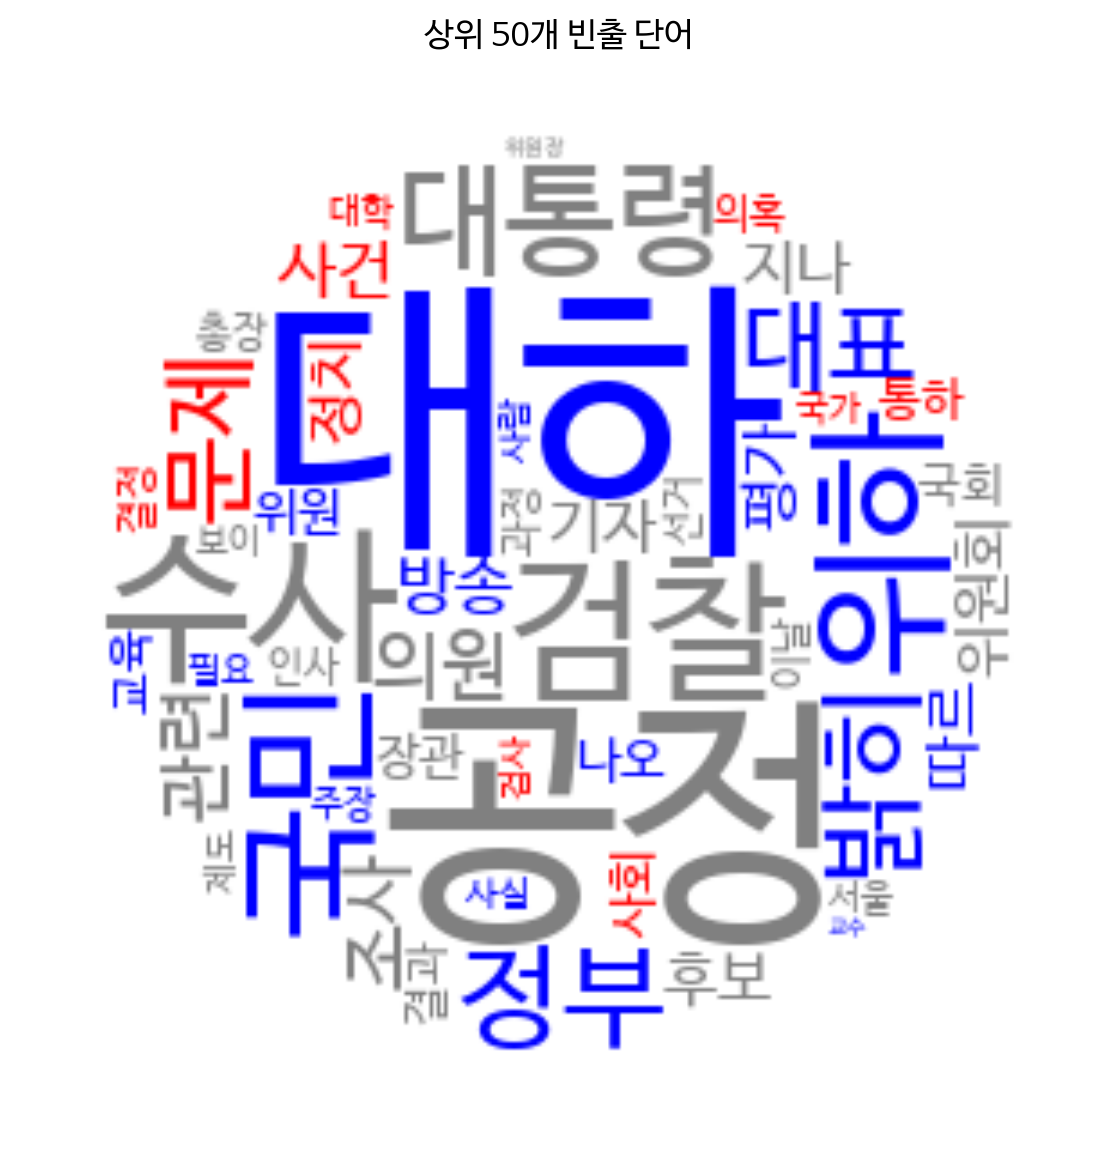

In [ ]:
# 상위 50개 단어 빈도
vec = CountVectorizer(ngram_range=(1,1), min_df=1, max_df=1.0)
X = vec.fit_transform(df1['Tokens'])
vocab = vec.get_feature_names_out()
counts = np.asarray(X.sum(axis=0)).ravel()
freq_all = dict(zip(vocab, counts))
TOP_N = 50
top50 = dict(sorted(freq_all.items(), key=lambda x: x[1], reverse=True)[:TOP_N])

# 각 단어를 단독 문장으로 보고 tokenize → get_score의 부호로 색(-/0/+)
sign_map = {}
for w in top50.keys():
    toks = ksa.tokenize(w)
    raw = ksa.get_score(toks)  # 딕셔너리 또는 숫자일 수 있음

    # 스칼라/딕셔너리 모두 대응
    if isinstance(raw, dict):
        # 1순위: Polarity 사용 (양수=긍정, 음수=부정)
        s = raw.get('Polarity', 0)
        # Polarity가 없다면 대체로 Positive+Negative 합을 사용
        if s == 0 and ('Positive' in raw or 'Negative' in raw):
            s = float(raw.get('Positive', 0)) + float(raw.get('Negative', 0))
    else:
        s = float(raw)

    sign_map[w] = 1 if s > 0 else (-1 if s < 0 else 0)

# 이후 과정은 이전의 워드클라우드와 거의 동일함
x, y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

# 단어의 극성 확인해서 긍정은 blue, 부정은 red, 중립은 gray 로 단어별 색깔 처리 입력
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    s = sign_map.get(word, 0)
    if s > 0: return "blue"
    if s < 0: return "red"
    return "gray"

wc = WordCloud(font_path=fontpath, background_color='white', mask=mask).generate_from_frequencies(top50)
wc = wc.recolor(color_func=color_func)

plt.figure(figsize=(7,7))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('상위 50개 빈출 단어')
plt.show()

#  Deep Learning 기반 감성 분석 테스트하기
* KOTE: https://github.com/searle-j/KOTE
* 다양한 플랫폼에서 수집한 50,000개의 댓글에 44개 정서로 레이블링한 데이터셋을 기반으로 분석

In [ ]:
!pip install pytorch_lightning -q # “훈련 루프”를 깔끔하게 추상화해 주는 프레임워크(LightningModule에 모델·손실·옵티마이저·step 로직을 정의하고 Trainer로 학습/검증/테스트/추론, 멀티-GPU/TPU 등을 제어)
!pip install transformers -q # BERT/ELECTRA/GPT 등 사전학습(Pretrained) 모델과 토크나이저를 손쉽게 불러와 fine-tuning/추론을 돕는 라이브러리
!pip install torch -q # 텐서 연산, 자동 미분(autograd), GPU 가속, 모델/옵티마이저/데이터로더 등 딥러닝의 뼈대가 되는 라이브러리

from tqdm import tqdm # 반복문 진행 상황을 표시하는 진행바

import pytorch_lightning as pl
import torch.nn as nn
from transformers import ElectraModel, AutoTokenizer, AutoModel
import torch

In [ ]:
# KOTE에서 제시한 44개 감정 라벨

LABELS = ['불평/불만', '환영/호의', '감동/감탄', '지긋지긋', '고마움', '슬픔', '화남/분노', '존경', '기대감', '우쭐댐/무시함', '안타까움/실망', '비장함', '의심/불신', '뿌듯함', '편안/쾌적',
          '신기함/관심', '아껴주는', '부끄러움', '공포/무서움', '절망', '한심함', '역겨움/징그러움', '짜증', '어이없음', '없음', '패배/자기혐오', '귀찮음', '힘듦/지침', '즐거움/신남',
          '깨달음', '죄책감', '증오/혐오', '흐뭇함(귀여움/예쁨)', '당황/난처', '경악', '부담/안_내킴', '서러움', '재미없음', '불쌍함/연민', '놀람', '행복', '불안/걱정', '기쁨', '안심/신뢰']

device = "cuda" if torch.cuda.is_available() else "cpu" # CUDA 사용 가능 여부에 따라 실행 장치 설정

class KOTEtagger(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.electra = ElectraModel.from_pretrained("beomi/KcELECTRA-base", revision='v2021').to(device)  # 사전학습 ELECTRA 모델 불러오기
        self.tokenizer = AutoTokenizer.from_pretrained("beomi/KcELECTRA-base", revision='v2021')  # 해당 ELECTRA 모델의 토크나이저 로드
        self.classifier = nn.Linear(self.electra.config.hidden_size, 44).to(device)  # 44개 감정 라벨에 대한 출력층 정의

    def forward(self, text:str):
        # 입력 텍스트를 토크나이저로 텐서화
        encoding = self.tokenizer.encode_plus(
          text,
          add_special_tokens=True,  # 특수 토큰 추가 ([CLS], [SEP] 등)
          max_length=512,  # 최대 길이 제한
          return_token_type_ids=False,  # 토큰 타입 ID는 사용하지 않음
          padding="max_length",  # max_length 기준으로 패딩
          return_attention_mask=True,  # attention mask 반환
          return_tensors='pt',  # PyTorch 텐서 형태로 반환
        ).to(device)

        output = self.electra(encoding["input_ids"], attention_mask=encoding["attention_mask"])  # ELECTRA 모델 실행
        output = output.last_hidden_state[:,0,:]  # [CLS] 토큰 위치의 임베딩 사용
        output = self.classifier(output)  # 선형 분류기 통과 → 44차원 로짓
        output = torch.sigmoid(output) # 다중 레이블 가정(sigmoid로 각 라벨 독립 확률로 해석)
        torch.cuda.empty_cache()  # GPU 메모리 캐시 비우기

        return output

trained_model = KOTEtagger()
trained_model.load_state_dict(torch.load("/content/drive/MyDrive/CLASS/202502_NLP/강의 코드 및 슬라이드/kote_pytorch_lightning.bin"), strict=False) # 외부에 저장된 가중치 로드

_IncompatibleKeys(missing_keys=[], unexpected_keys=['electra.embeddings.position_ids'])

In [ ]:
preds = trained_model("재미있어요! 재미는 확실히 있는데 뭐랄까... 너무 정신없달까...ㅋㅋ")[0]

for l, p in zip(LABELS, preds):
    if p>0.4:
        print(f"{l}: {p}")

불평/불만: 0.6502271294593811
안타까움/실망: 0.7632464170455933
어이없음: 0.4877130687236786
즐거움/신남: 0.8589890003204346
당황/난처: 0.6052669882774353
재미없음: 0.4886167645454407
기쁨: 0.4897279143333435


In [ ]:
# KcELECTRA 토크나이저 준비
tokenizer = AutoTokenizer.from_pretrained("beomi/KcELECTRA-base", revision="v2021")

# 각 문장의 토큰 길이 계산 함수
def token_len(text):
    if text is None:
        text = "" # 결측값 방지: None이면 빈 문자열로 처리(특수 토큰 길이만 남게 됨)
    enc = tokenizer.encode_plus(
        str(text),
        add_special_tokens=True, # [CLS], [SEP] 등 특수 토큰 포함 -> 길이에도 포함됨
        padding=False, # 패딩 미적용(실제 토큰화 결과의 원래 길이 측정)
        truncation=False, # 자르지 않음(길이를 정확히 알고 싶기 때문)
        return_tensors="pt"
    )
    return enc["input_ids"].shape[1]

# 길이 컬럼 추가
df1["seq_len"] = df1["Tokens"].apply(token_len)

# 512 초과 제거(ELECTRA/BERT류 최대 입력 길이를 넘는 샘플 필터링)
before = len(df1)
df2 = df1[df1["seq_len"] <= 512].copy() # 위에서 max_length 가 512로 설정되어 있으므로 이를 초과하는 문서는 오류가 발생함(물론 파라미터로 처리는 가능하나 여기서는 지나치게 긴 문서를 제거하는 방향으로 진행)
df2.reset_index(drop=True, inplace=True)
df2

Token indices sequence length is longer than the specified maximum sequence length for this model (1811 > 512). Running this sequence through the model will result in indexing errors


,index,Date,Url,Title,Content,News,Style,Year,Char,Nouns,...,Admin,Period\r,Tokens,Tokenize,KNU_hits,KNU_score,KNU_summary,ksa_tokens,ksa_score,seq_len
0,2050,2019.11.28,https://www.chosun.com/site/data/html_dir/2019...,"[단독] '겨울왕국2' 스크린 2648개↑점유율 79%→디즈니 ""공식입장無""..무법...",[OSEN=김보라 기자] 영화 ‘겨울왕국2’가 1편 ‘겨울왕국’(2014)에 이어 ...,조선,Con,2019,160,김보라 기자 영화 겨울왕국 겨울왕국 관객 돌파 모양새 관객 돌파 평일 일일 관객 극...,...,Pro,5,김보라 기자 영화 겨울왕국 겨울왕국 다시 관객 돌파 모양새 관객 돌파 앞서 평일 무...,"[김보라, 기자, 영화, 겨울왕국, 겨울왕국, 다시, 관객, 돌파, 모양새, 관객,...","[(김보라, None, None), (기자, None, None), (영화, Non...",10.0,"{'pos_freq': 16, 'neg_freq': 8, 'pos_sum': 21....","[영화/NNG, 겨울/NNG, 겨울/NNG, 다시/MAG, 앞/NNG, 극장/NNG...","{'Positive': 62, 'Negative': -33, 'Polarity': ...",231
1,3292,2017.10.13,https://www.chosun.com/site/data/html_dir/2017...,"SBS, 한국 방송 초유의 '사장 임명동의제' 도입",SBS와 SBS 노동조합은 지난 9월 11일 윤세영 회장의 소유와 경영 분리 선언을...,조선,Con,2017,105,노동조합 윤세영 회장 소유 경영 분리 선언 실행 후속 조치 합의 편성 시사 교양 보...,...,Pro,3,노동조합 지나 윤세영 회장 소유 경영 분리 선언 실행 후속 조치 합의 편성 시사 교...,"[노동조합, 지나, 윤세영, 회장, 소유, 경영, 분리, 선언, 실행, 후속, 조치...","[(노동조합, None, None), (지나, None, None), (윤세영, N...",2.0,"{'pos_freq': 10, 'neg_freq': 7, 'pos_sum': 13....","[선언/NNG, 합의/NNG, 최고/NNG, 대표/NNG, 동의/NNG, 대표/NN...","{'Positive': 24, 'Negative': -18, 'Polarity': ...",141
2,18082,2020. 12. 15,https://www.khan.co.kr/article/202012152056005,윤 총장 측 ‘하루 연장’ 요청했지만 거부…최후진술 없이 종결,법무부 검사징계위원회는 15일 2차 심의를 열고 윤석열 검찰총장에 대한 징계 여부를...,경향,Pro,2020,384,법무부 검사 징계 위원회 심의 윤석열 검찰 총장 징계 여부 논의 징계위 총장 저녁 ...,...,Pro,6,법무부 검사 징계 위원회 심의 윤석열 검찰 총장 대하 징계 여부 논의 징계위 총장 ...,"[법무부, 검사, 징계, 위원회, 심의, 윤석열, 검찰, 총장, 대하, 징계, 여부...","[(법무부, None, None), (검사, None, None), (징계, Non...",-17.0,"{'pos_freq': 10, 'neg_freq': 21, 'pos_sum': 13...","[검사/NNG, 열/VV, 여부/NNG, 논의/NNG, 최후/NNG, 정부/NNG,...","{'Positive': 44, 'Negative': -66, 'Polarity': ...",484
3,16475,2023-12-10,https://www.hani.co.kr/arti/opinion/column/111...,브로커와 매관매직,[한겨레 프리즘] 박수지 | 이슈팀장 “나 청와대 실장인데….” 2021년 말께 자...,한겨레,Pro,2023,252,한겨레 프리즘 수지 이슈 팀장 청와대 실장 자신 소개 사람 서울경찰청장 전화 서울 ...,...,Con,9,한겨레 프리즘 수지 이슈 팀장 청와대 실장 자신 소개 사람 서울 경찰청장 직접 전화...,"[한겨레, 프리즘, 수지, 이슈, 팀장, 청와대, 실장, 자신, 소개, 사람, 서울...","[(한겨레, None, None), (프리즘, None, None), (수지, No...",5.0,"{'pos_freq': 23, 'neg_freq': 16, 'pos_sum': 32...","[소개/NNG, 사람/NNG, 직접/NNG, 전화/NNG, 과장/NNG, 승진/NN...","{'Positive': 54, 'Negative': -53, 'Polarity': ...",362
4,10281,2016-11-24,https://www.donga.com/news/article/all/2016112...,새누리 정진석-민주 우상호 SNS로 질의·응답…무슨 내용 담겼나?,"정진석, 우상호. 동아일보DB새누리당 정진석 원내대표와 더불어민주당 우상호 원내대표...",동아,Con,2016,233,정진석 우상호 동아일보 새누리당 정진석 원내 대표 더불어민주당 우상호 원내 대표 민...,...,Con,2,정진석 우상호 동아일보 새누리당 정진석 원내 대표 더불어민주당 우상호 원내 대표 민...,"[정진석, 우상호, 동아일보, 새누리당, 정진석, 원내, 대표, 더불어민주당, 우상...","[(정진석, None, None), (우상호, None, None), (동아일보, ...",19.0,"{'pos_freq': 25, 'neg_freq': 10, 'pos_sum': 33...","[정/NNG, 정/NNG, 대표/NNG, 대표/NNG, 처리/NNG, 의견/NNG,...","{'Positive': 59, 'Negative': -34, 'Polarity': ...",305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1737,8550,2019-11-04,https://www.donga.com/news/article/all/2019110...,각계 인사 1492명 시국선언…“정시확대 추진 취소하라”,4일 오전 서울 중구 프레스센터에서 열린 대입 공정성을 넘어 특권 대물림 교육 중단...,동아,Con,2019,184,오전 서울 중구 프레스센터 대입 공정 특권 대물림 교육 중단 촉구 시국 선언 기자 ...,...,Pro,5,오전 서울 중구 프레스센터 열리 대입 공정 특권 대물림 교육 중단 촉구 시국 선언 ...,"[오전, 서울, 중구, 프레스센터, 열리, 대입, 공정, 특권, 대물림, 교육, 중...","[(오전, None, None), (서울, None, None), (중구, None...",16.0,"{'pos_freq': 22, 'neg_freq': 10, 'pos_sum': 31...","[대입/NNG, 교육/NNG, 중단/NNG, 선언/NNG, 교육/NNG, 단체/NN...","{'Positive': 48, 'Negative': -45, 'Polarity': ...",236
1738,14711,2018-02-12,https://www.hani.co.kr/arti/politics/defense/8...,군 지휘관 ‘재판 개입’ 차단…군 법원장 민간 법조인으로,"국방부가 12일 발표한 군 사법개혁안은 군사재판의 독립성과 공정성을 확보해, 군 사...",한겨레,Pro,2018,337,국방부 발표 사법 개혁 군사 재판 독립 공정 확보 사법 분야 장병 인권 보장 중점 ...,...,Pro,4,국방부 발표 사법 개혁 군사 재판 독립 공정 확보 사법 분야 장병 인권 보장 중점 ...,"[국방부, 발표, 사법, 개혁, 군사, 재판, 독립, 공정, 확보, 사법, 분야, ...","[(국방부, None, None), (발표, None, None), (사법, Non...",-4.0,"{'pos_freq': 18, 'neg_freq': 19, 'pos_sum': 22...","[발표/NNG, 독립/NNG, 확보/NNG, 분야/NNG

In [ ]:
neg_p = []  # 부정 감정 평균 점수 저장 리스트
pos_p = []  # 긍정 감정 평균 점수 저장 리스트
mean_p = []  # 전체 감정 점수 평균 저장 리스트
labels = []  # 감지된 감정 레이블 저장 리스트
values = []  # 감정 점수 저장 리스트

# 감정 라벨 분류: 긍정/부정/중립
pos = ['환영/호의', '감동/감탄', '고마움', '존경', '기대감', '뿌듯함', '편안/쾌적', '신기함/관심', '아껴주는', '즐거움/신남', '흐뭇함(귀여움/예쁨)', '행복', '기쁨', '안심/신뢰']
neg = ['불평/불만', '지긋지긋', '슬픔', '화남/분노', '안타까움/실망', '의심/불신', '부끄러움', '공포/무서움', '절망', '한심함', '역겨움/징그러움', '짜증', '어이없음',
       '패배/자기혐오', '귀찮음', '힘듦/지침', '죄책감', '증오/혐오', '당황/난처', '경악', '부담/안_내킴', '서러움', '재미없음', '불쌍함/연민', '불안/걱정']
neu = ['우쭐댐/무시함', '비장함', '없음', '깨달음', '놀람']

# 전체 텍스트에 대해 감정 추론 수행
for text in tqdm(df2['Tokens']):
    preds = trained_model(text)[0]  # 감정 예측 확률 반환
    test = []  # 감지된 감정 레이블 저장
    test1 = []  # 해당 감정의 예측 점수 저장
    test2 = []  # 긍/부/중립에 따라 점수 조정하여 저장

    # 예측된 감정 중 threshold(0.4) 이상인 항목만 저장
    for label, value in zip(LABELS, preds):
        if value>0.4:
            test.append(label)
            test1.append(round(value.item(), 2))
    labels.append(test)

    # 감정 라벨 분류별 점수 부여: 부정은 음수, 긍정은 양수, 중립은 0
    for l, s in zip(test, test1):
        if l in neg:
            test2.append(s * -1)
        elif l in neu:
            test2.append(0)
        elif l in pos:
            test2.append(s)
    values.append(test2)

    # 긍정 및 부정 점수 분리
    positive_numbers = []
    negative_numbers = []

    for num in test2:
        if num > 0:
            positive_numbers.append(num)
        elif num < 0:
            negative_numbers.append(num)

    # 각 감정 점수 평균값 계산 (감정 없을 경우 0 처리)
    try:
        positive = round(sum(positive_numbers) / len(positive_numbers), 3)
        pos_p.append(positive)
    except:
        positive = 0
        pos_p.append(positive)
    try:
        negative = round(sum(negative_numbers) / len(negative_numbers), 3)
        neg_p.append(negative)
    except:
        negative = 0
        neg_p.append(negative)

    mean_p.append(round(positive + negative, 3))

100%|██████████| 1742/1742 [1:00:03<00:00,  2.07s/it]


In [ ]:
df2['Sentiment_label'] = [', '.join(map(str, lst)) for lst in labels]
df2['Sentiment_values'] = [', '.join(map(str, lst)) for lst in values]
df2['Sentiment_pos'] = pos_p
df2['Sentiment_neg'] = neg_p
df2['Sentiment_mean'] = mean_p

df2

,index,Date,Url,Title,Content,News,Style,Year,Char,Nouns,...,KNU_score,KNU_summary,ksa_tokens,ksa_score,seq_len,Sentiment_label,Sentiment_values,Sentiment_pos,Sentiment_neg,Sentiment_mean
0,2050,2019.11.28,https://www.chosun.com/site/data/html_dir/2019...,"[단독] '겨울왕국2' 스크린 2648개↑점유율 79%→디즈니 ""공식입장無""..무법...",[OSEN=김보라 기자] 영화 ‘겨울왕국2’가 1편 ‘겨울왕국’(2014)에 이어 ...,조선,Con,2019,160,김보라 기자 영화 겨울왕국 겨울왕국 관객 돌파 모양새 관객 돌파 평일 일일 관객 극...,...,10.0,"{'pos_freq': 16, 'neg_freq': 8, 'pos_sum': 21....","[영화/NNG, 겨울/NNG, 겨울/NNG, 다시/MAG, 앞/NNG, 극장/NNG...","{'Positive': 62, 'Negative': -33, 'Polarity': ...",231,"불평/불만, 기대감, 안타까움/실망, 없음","-0.64, 0.42, -0.6, 0",0.42,-0.620,-0.200
1,3292,2017.10.13,https://www.chosun.com/site/data/html_dir/2017...,"SBS, 한국 방송 초유의 '사장 임명동의제' 도입",SBS와 SBS 노동조합은 지난 9월 11일 윤세영 회장의 소유와 경영 분리 선언을...,조선,Con,2017,105,노동조합 윤세영 회장 소유 경영 분리 선언 실행 후속 조치 합의 편성 시사 교양 보...,...,2.0,"{'pos_freq': 10, 'neg_freq': 7, 'pos_sum': 13....","[선언/NNG, 합의/NNG, 최고/NNG, 대표/NNG, 동의/NNG, 대표/NN...","{'Positive': 24, 'Negative': -18, 'Polarity': ...",141,"기대감, 비장함, 없음","0.58, 0, 0",0.58,0.000,0.580
2,18082,2020. 12. 15,https://www.khan.co.kr/article/202012152056005,윤 총장 측 ‘하루 연장’ 요청했지만 거부…최후진술 없이 종결,법무부 검사징계위원회는 15일 2차 심의를 열고 윤석열 검찰총장에 대한 징계 여부를...,경향,Pro,2020,384,법무부 검사 징계 위원회 심의 윤석열 검찰 총장 징계 여부 논의 징계위 총장 저녁 ...,...,-17.0,"{'pos_freq': 10, 'neg_freq': 21, 'pos_sum': 13...","[검사/NNG, 열/VV, 여부/NNG, 논의/NNG, 최후/NNG, 정부/NNG,...","{'Positive': 44, 'Negative': -66, 'Polarity': ...",484,"화남/분노, 의심/불신, 없음","-0.42, -0.48, 0",0.00,-0.450,-0.450
3,16475,2023-12-10,https://www.hani.co.kr/arti/opinion/column/111...,브로커와 매관매직,[한겨레 프리즘] 박수지 | 이슈팀장 “나 청와대 실장인데….” 2021년 말께 자...,한겨레,Pro,2023,252,한겨레 프리즘 수지 이슈 팀장 청와대 실장 자신 소개 사람 서울경찰청장 전화 서울 ...,...,5.0,"{'pos_freq': 23, 'neg_freq': 16, 'pos_sum': 32...","[소개/NNG, 사람/NNG, 직접/NNG, 전화/NNG, 과장/NNG, 승진/NN...","{'Positive': 54, 'Negative': -53, 'Polarity': ...",362,"불평/불만, 화남/분노, 안타까움/실망, 의심/불신, 짜증, 없음, 불안/걱정","-0.77, -0.79, -0.57, -0.77, -0.47, 0, -0.44",0.00,-0.635,-0.635
4,10281,2016-11-24,https://www.donga.com/news/article/all/2016112...,새누리 정진석-민주 우상호 SNS로 질의·응답…무슨 내용 담겼나?,"정진석, 우상호. 동아일보DB새누리당 정진석 원내대표와 더불어민주당 우상호 원내대표...",동아,Con,2016,233,정진석 우상호 동아일보 새누리당 정진석 원내 대표 더불어민주당 우상호 원내 대표 민...,...,19.0,"{'pos_freq': 25, 'neg_freq': 10, 'pos_sum': 33...","[정/NNG, 정/NNG, 대표/NNG, 대표/NNG, 처리/NNG, 의견/NNG,...","{'Positive': 59, 'Negative': -34, 'Polarity': ...",305,"기대감, 비장함, 없음","0.5, 0, 0",0.50,0.000,0.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1737,8550,2019-11-04,https://www.donga.com/news/article/all/2019110...,각계 인사 1492명 시국선언…“정시확대 추진 취소하라”,4일 오전 서울 중구 프레스센터에서 열린 대입 공정성을 넘어 특권 대물림 교육 중단...,동아,Con,2019,184,오전 서울 중구 프레스센터 대입 공정 특권 대물림 교육 중단 촉구 시국 선언 기자 ...,...,16.0,"{'pos_freq': 22, 'neg_freq': 10, 'pos_sum': 31...","[대입/NNG, 교육/NNG, 중단/NNG, 선언/NNG, 교육/NNG, 단체/NN...","{'Positive': 48, 'Negative': -45, 'Polarity': ...",236,"불평/불만, 화남/분노, 안타까움/실망, 비장함, 의심/불신, 없음, 불안/걱정","-0.75, -0.77, -0.63, 0, -0.69, 0, -0.59",0.00,-0.686,-0.686
1738,14711,2018-02-12,https://www.hani.co.kr/arti/politics/defense/8...,군 지휘관 ‘재판 개입’ 차단…군 법원장 민간 법조인으로,"국방부가 12일 발표한 군 사법개혁안은 군사재판의 독립성과 공정성을 확보해, 군 사...",한겨레,Pro,2018,337,국방부 발표 사법 개혁 군사 재판 독립 공정 확보 사법 분야 장병 인권 보장 중점 ...,...,-4.0,"{'pos_freq': 18, 'neg_freq': 19, 'pos_sum': 22...","[발표/NNG, 독립/NNG, 확보/NNG, 분야/NNG, 인권/NNG, 보장/NN...","{'Positive': 50, 'Negative': -67, 'Polarity': ...",410,"비장함, 없음","0, 0",0.00,0.000,0.000
1739,15611,2015-11-20,https://www.hani.co.kr/arti/society/society_ge...,노동법도 ‘합의’ 무시…‘민주주의 시계’ 거꾸로 돈다,전국교직원노동조합 소속 교사들이 20일 오후 서울 태평로1가 서울파이낸스센터 앞에서...,한겨레,Pro,2015,332,전국교직원노동조합 소속 교사 오후 서울 태평로 서울 파이낸스 센터 역사 교과서 국정...,...,-13.0,"{'pos_freq': 9, 'neg_freq': 18, 'pos_sum': 13....","[전국/NNG, 노동/NNG, 역사/NNG, 투쟁/NNG, 전국/NNG, 결의/NN...","{'Positive': 74, 'Negative': -68, 'Polarity': ...",425,"불평/불만, 화남/분노, 안타까움/실망, 의심/불신, 짜증, 없음, 불안/걱정","-0.73, -0.67, -0.55, -0.71, -0.43, 0, -0.56",0.00,-0.608,-0.608
1740,3085,2018.02.06,https://www.chosun.co

In [ ]:
df2['Sentiment_pos'] = pd.to_numeric(df2['Sentiment_pos'], errors='coerce')
df2['Sentiment_neg'] = pd.to_numeric(df2['Sentiment_neg'], errors='coerce')

test  = df2.groupby('Year')['Sentiment_pos'].mean()
test1 = df2.groupby('Year')['Sentiment_neg'].mean()

/tmp/ipython-input-2425133929.py:17: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  plt.tight_layout()


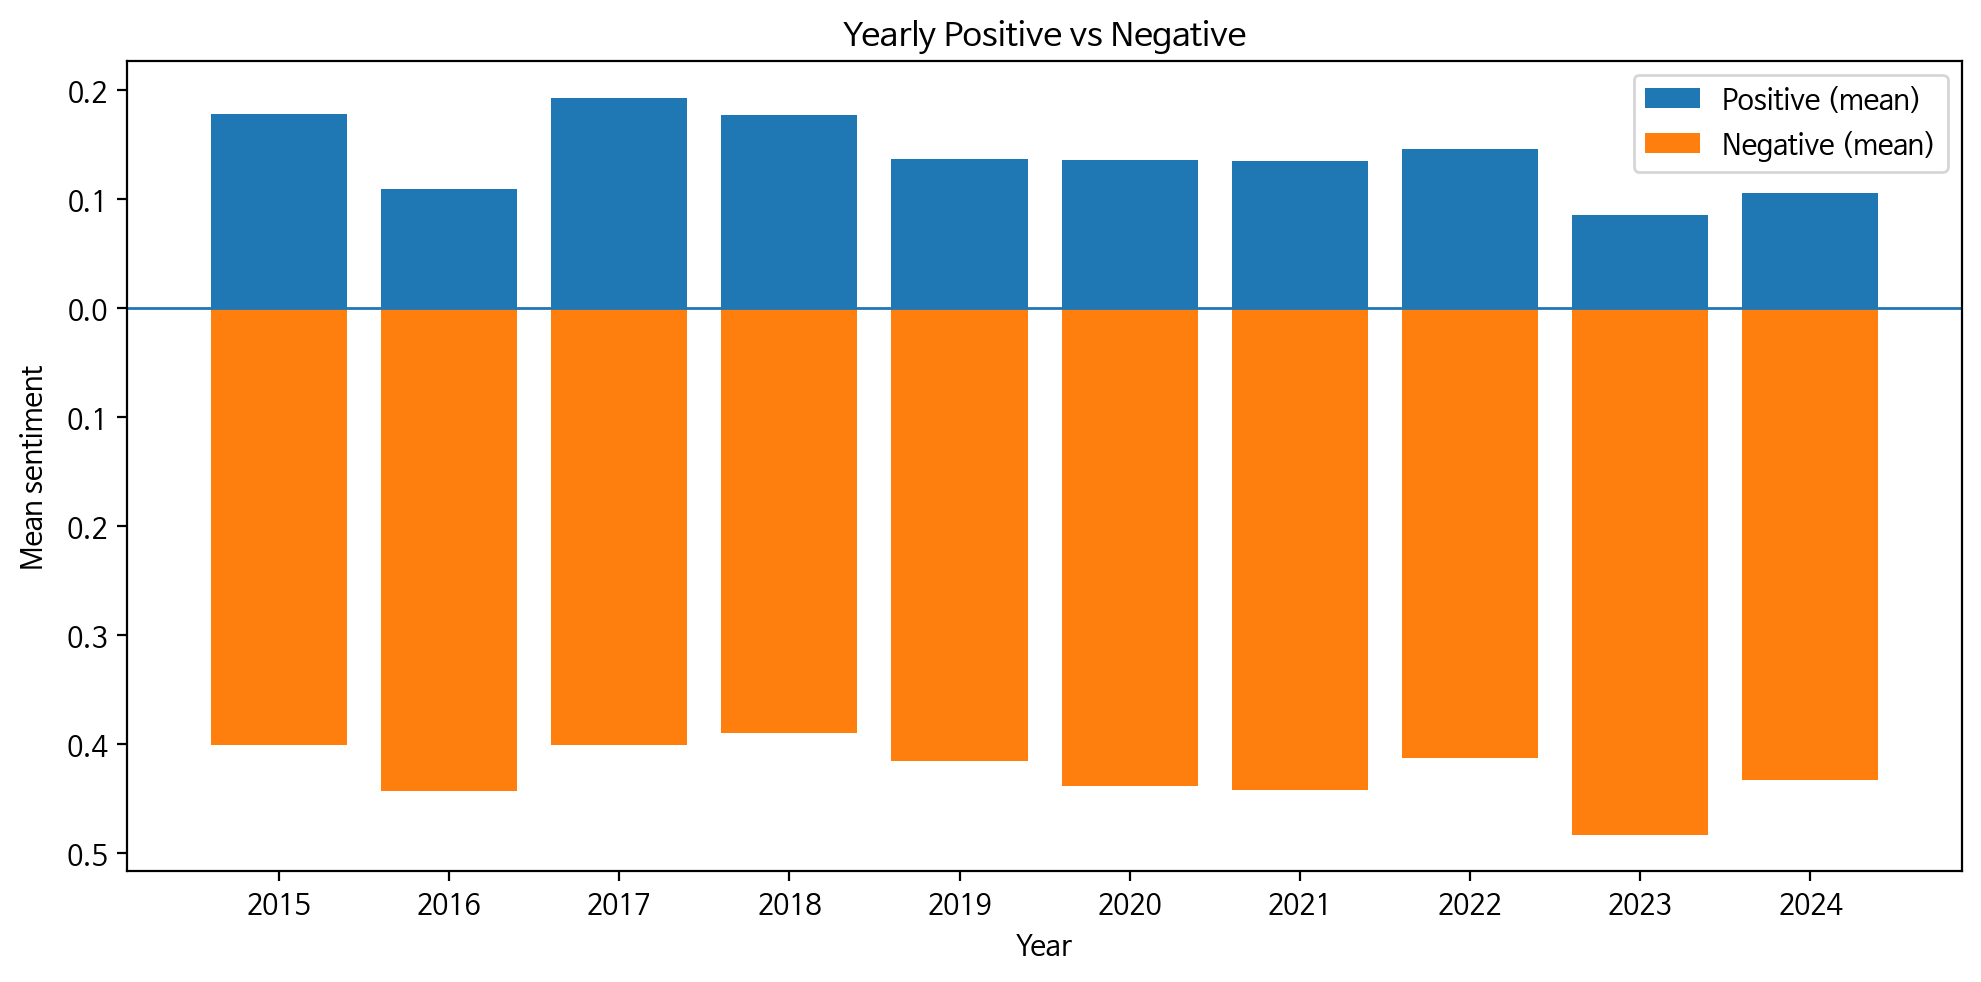

In [ ]:
years = sorted(set(test.index).union(set(test1.index)))
pos = pd.Series(test).reindex(years).fillna(0.0)
neg = pd.Series(test1).reindex(years).fillna(0.0)

# 부정값이 양수(크기)로 되어 있다면 아래로 내려가도록 부호 반전
neg_plot = (-neg) if (neg >= 0).all() else neg

plt.figure(figsize=(10,5))
plt.bar(years, pos.values, label='Positive (mean)')
plt.bar(years, neg_plot.values, label='Negative (mean)')  # 음수면 아래로 그려짐
plt.axhline(0, linewidth=1)  # 기준선
plt.xlabel('Year')
plt.ylabel('Mean sentiment')
plt.title('Yearly Positive vs Negative')
plt.xticks(years)
plt.legend()
plt.tight_layout()
plt.show()
